In [ ]:
import FindMattes as fm
from os import listdir
import os
from os.path import join

In [ ]:
directoryName = "F:\\rotoscoping\\images"
matteHeight = 256

In [ ]:
fm.createMatte("F:\\rotoscoping\\testimage.png", "F:\\rotoscoping\\testimage_matte.png", 256)

In [ ]:
listOfFiles = listdir(directoryName)

In [ ]:
for file in listOfFiles:
    sourceFile = join(directoryName, file)
    mainFileNamePos = file.find(".")
    filename = file[:mainFileNamePos] + "_matte" + file[mainFileNamePos:]
    filename = filename.replace(" ", "_")
    fulleMattePath = join(directoryName, filename)
    #print(fulleMattePath)
    fm.createMatte(sourceFile, fulleMattePath, matteHeight)

In [4]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.9.1
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_loc, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_loc.startswith("http"):
    image_path = tf.keras.utils.get_file(os.path.basename(image_loc)[-128:], image_loc)
  else:
    image_path = image_loc
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

In [ ]:
def ffwd_video(path_in, path_out, checkpoint_dir, device_t='/gpu:0', batch_size=1):
    hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
    hub_module = hub.load(hub_handle)
    video_clip = VideoFileClip(path_in, audio=False)

    # For outputting video it is imperative to produce the highest quality for post processing. 
    # I found that if this is the last step the quality goes to heck. 
    video_writer = ffmpeg_writer.FFMPEG_VideoWriter(path_out, video_clip.size, video_clip.fps, codec="libx264",
                                                    preset="veryslow", bitrate="90000k",    
                                                    audiofile=path_in, threads=None,
                                                    ffmpeg_params=None)

    config = tf.compat.v1.ConfigProto()
    #config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.8
    with  tf.compat.v1.Session(config=config) as sess:
        batch_shape = (batch_size, video_clip.size[1], video_clip.size[0], 3)
        img_placeholder = tf.compat.v1.placeholder(tf.float32, shape=batch_shape, name='img_placeholder')

        preds = transform.net(img_placeholder)
        saver = tf.compat.v1.train.Saver()

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        #print("Opening checkpoint: ", ckpt.model_checkpoint_path )
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            raise Exception("No checkpoint found...")

        X = np.zeros(batch_shape, dtype=np.float32)

        def style_and_write(count):
            for i in range(count, batch_size):
                X[i] = X[count - 1]  # Use last frame to fill X
            _preds = sess.run(preds, feed_dict={img_placeholder: X})
            #print("count", count, "leng", len(_preds))
            for i in range(0, count):
                video_writer.write_frame(np.clip(_preds[i], 0, 255).astype(np.uint8))
                
        total_frames = 0
        frame_count = 0  # The frame count that written to X
        for frame in video_clip.iter_frames():
            X[frame_count] = frame
            frame_count += 1
            total_frames +=1
            if frame_count == batch_size:
                style_and_write(frame_count)
                frame_count = 0
                print("frames processed:", total_frames)
        if frame_count != 0:
            style_and_write(frame_count)
        
            style_and_write(frame_count)
        print("FInishing up video. Total frames:", total_frames)
        video_clip.close()            
        video_writer.close()

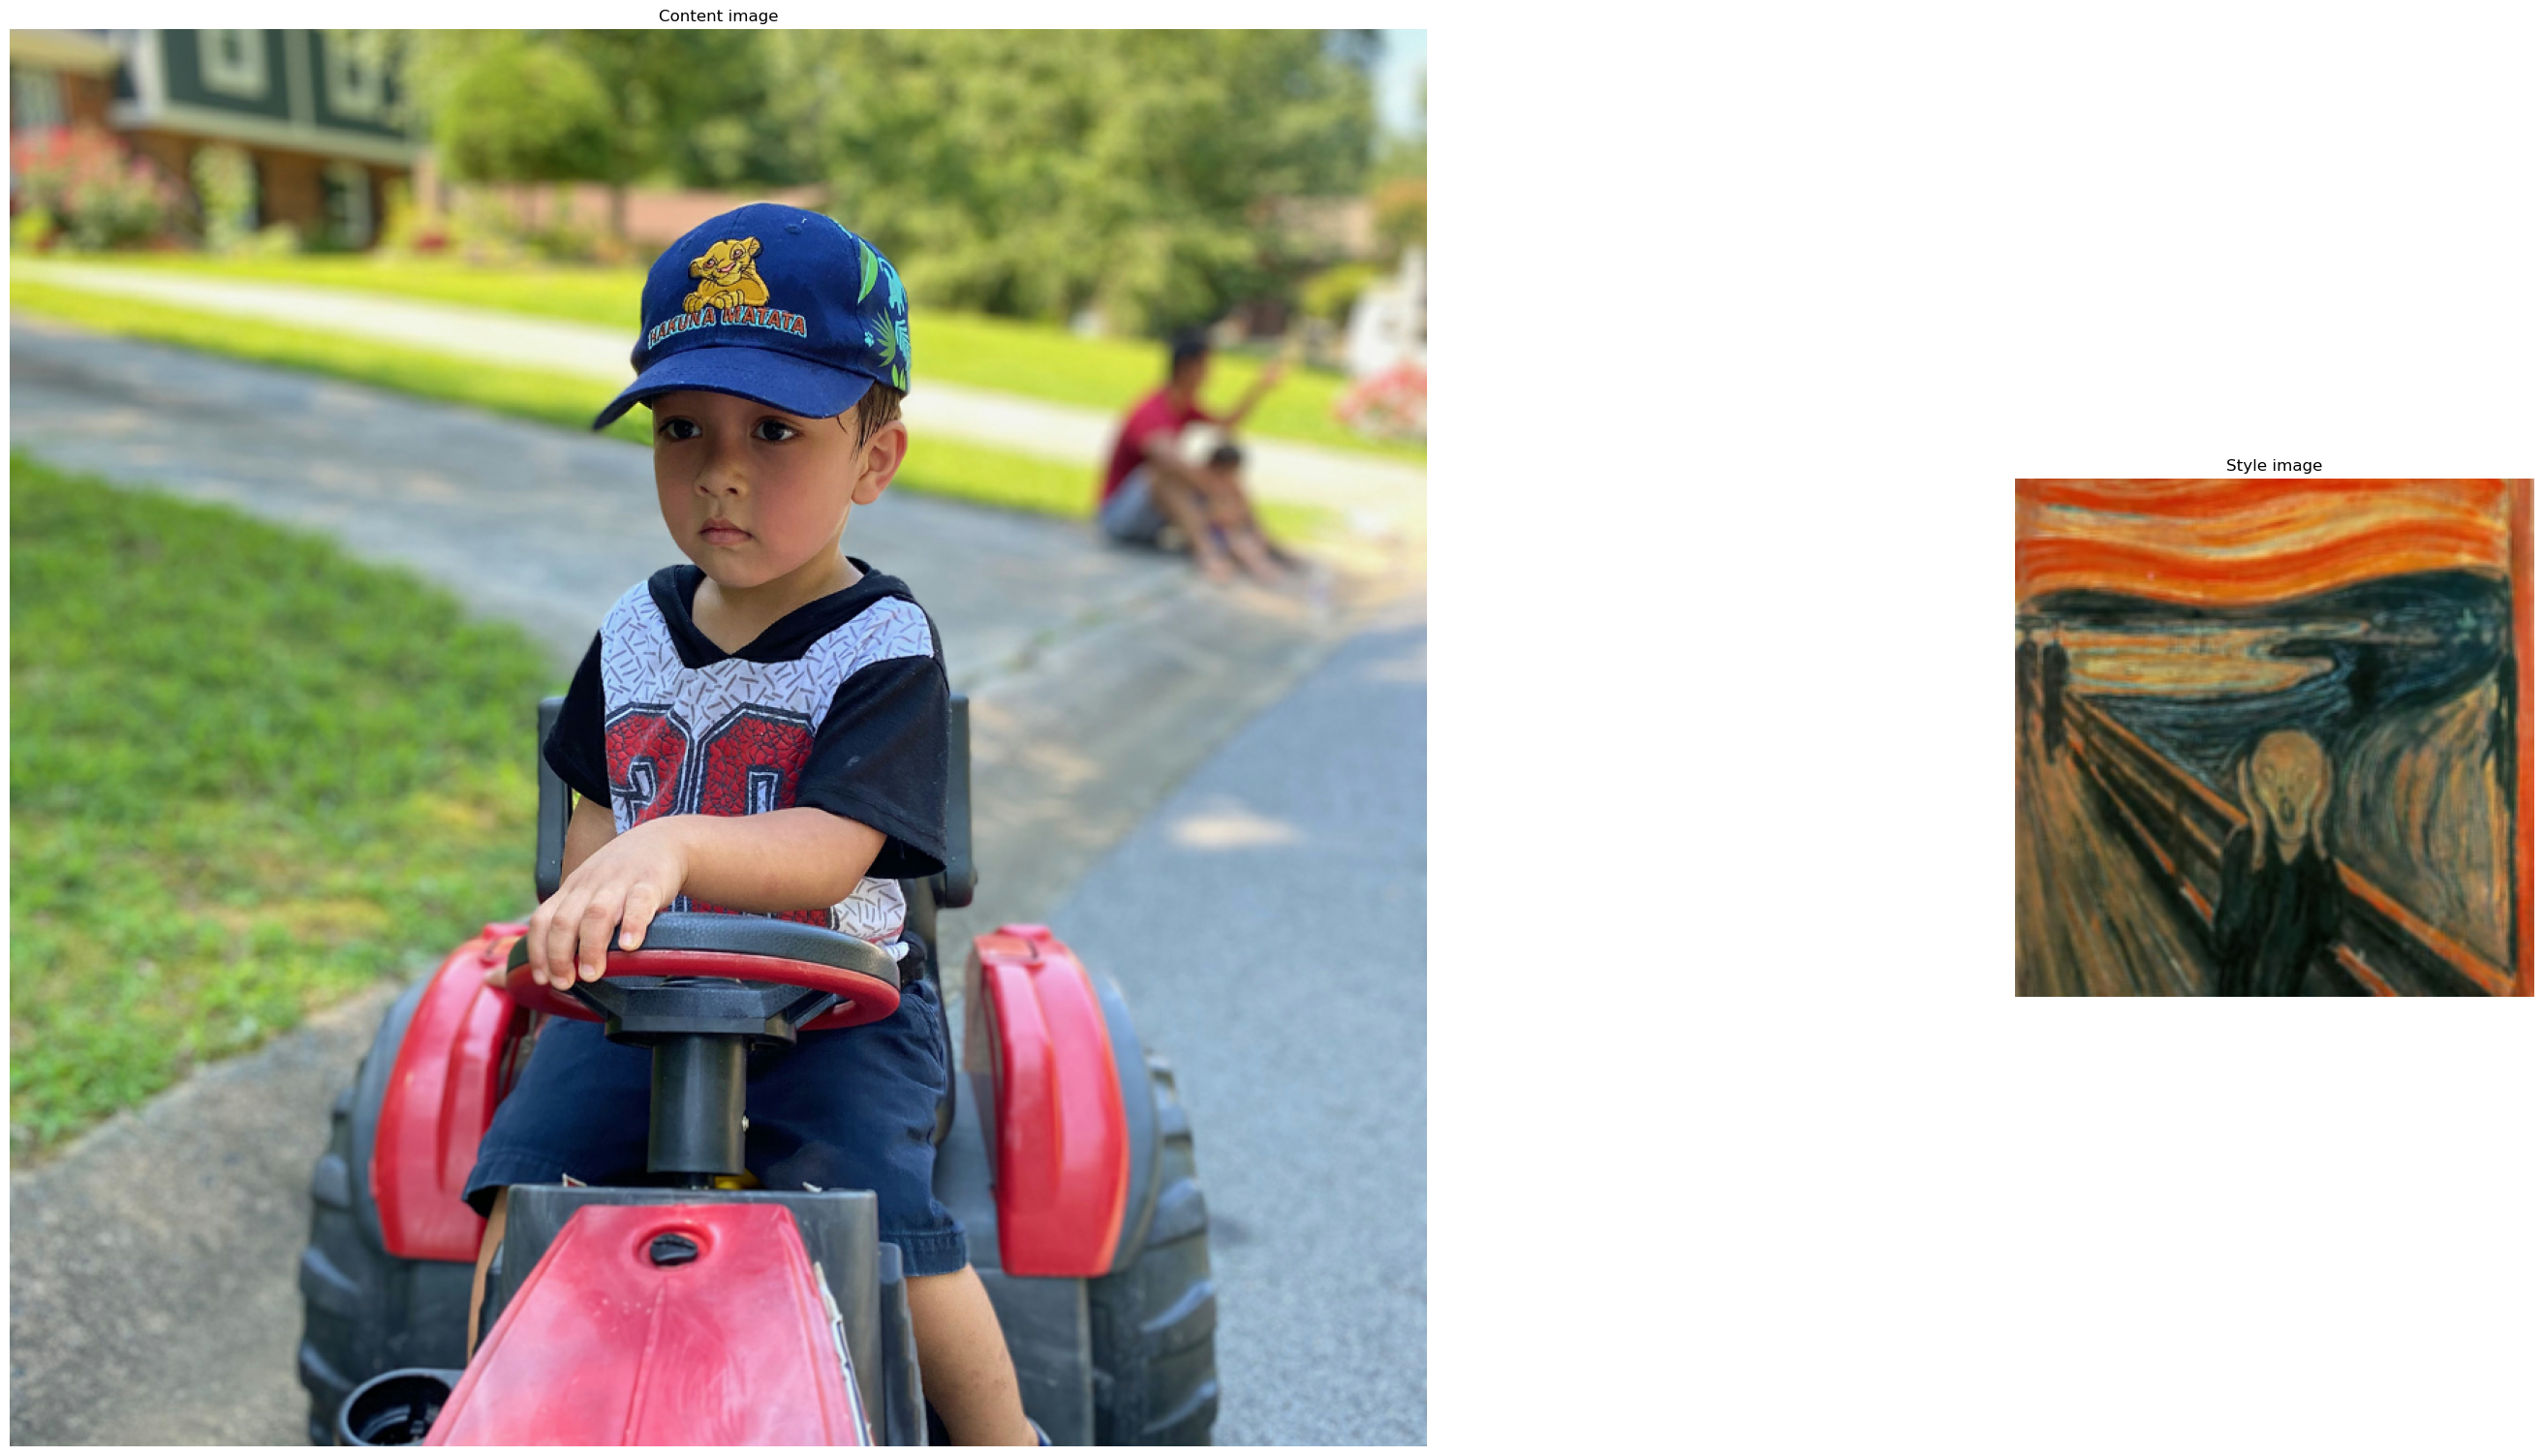

In [38]:
outPath = "F:/Real-time-style-transfers/eval-out"
# @title Load example images  { display-mode: "form" }
content_image_loc = "F:\\Real-time-style-transfers\\eval\\IMG_8454.JPG"
#content_image_loc = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'
#style_image_loc = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'
#style_image_loc = "F:\\Real-time-style-transfers\\styles-trained\\wave.jpg"
style_image_loc = "F:/Real-time-style-transfers/styles-trained/anime3.jpg"
output_image_size = 1024

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_loc, content_img_size)
style_image = load_image(style_image_loc, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [39]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [40]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

In [41]:
tf.keras.utils.save_img(outPath + "/" + "poopos-style.jpg", outputs[0][0])

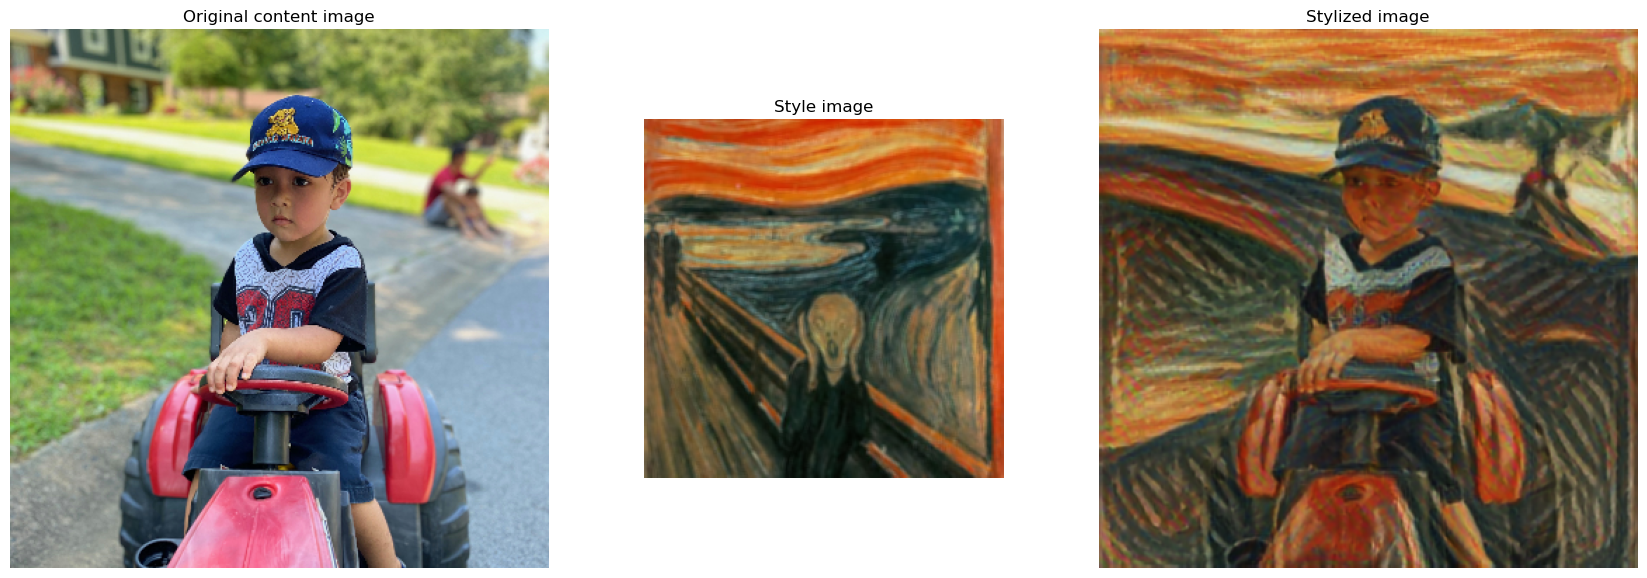

In [21]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])